In [1]:
# Dependencies
import pandas as pd
import os
import requests
import json
import gmaps
from ipywidgets.embed import embed_minimal_html
import matplotlib.pyplot as plt
import numpy as np 
import datetime
import warnings
warnings.filterwarnings("ignore")
#Google developer API key
from config import apikey
#Configure gmaps
gmaps.configure(api_key=apikey)

#Function to clean data
def clean_numbers(a):
    a = a.str.strip('$').str.replace(',', '').astype(float)
    return a

In [2]:
# Store filepath in a variable
file_one = "./listings.csv"
file_two = "./listings_calendar.csv"
# Read file
file_one_df = pd.read_csv(file_one, encoding="ISO-8859-1")
file_two_df =  pd.read_csv(file_two, encoding="ISO-8859-1")


In [3]:
#Remove useless columns
clean_df = file_one_df[["id","host_id","host_name", "guests_included","host_listings_count","neighbourhood_cleansed",
                        "zipcode","latitude",'longitude',"property_type","room_type","accommodates","bathrooms",
                        "bedrooms","beds","square_feet","price","minimum_nights","maximum_nights","has_availability",
                        "availability_365","number_of_reviews","review_scores_value"]]

In [4]:
#Data Cleansing

#Rename some columns
clean_df = clean_df.rename(columns={'neighbourhood_cleansed': 'neighbourhood'})

#Rename Neighbourhoods
clean_df["neighbourhood"] = clean_df["neighbourhood"].replace("Ward A (councilmember Denise Ridley)","Greenville")
clean_df["neighbourhood"] = clean_df["neighbourhood"].replace("Ward B (councilmember Mira Prinz-Arey)","West Side")
clean_df["neighbourhood"] = clean_df["neighbourhood"].replace("Ward C (councilmember Richard Boggiano)","Journal Square")
clean_df["neighbourhood"] = clean_df["neighbourhood"].replace("Ward D (councilmember Michael Yun)","Heights")
clean_df["neighbourhood"] = clean_df["neighbourhood"].replace("Ward E (councilmember James Solomon)","Downtown")
clean_df["neighbourhood"] = clean_df["neighbourhood"].replace("Ward F (councilmember Jermaine D. Robinson)","Bergen-Lafayette")

#Rename property types
clean_df["property_type"]= clean_df["property_type"].replace("Aparthotel", "Hotel")
clean_df["property_type"]= clean_df["property_type"].replace("Boutique hotel", "Hotel")
clean_df["property_type"]= clean_df["property_type"].replace("Serviced apartment", "Apartment")
clean_df["property_type"]= clean_df["property_type"].replace("Condominium", "Apartment")
clean_df["property_type"]= clean_df["property_type"].replace("Bed and breakfast", "Apartment")
clean_df["property_type"]= clean_df["property_type"].replace("Guest suite", "Apartment")
clean_df["property_type"]= clean_df["property_type"].replace("Guesthouse", "Apartment")
clean_df["property_type"]= clean_df["property_type"].replace("Loft", "Apartment")
clean_df["property_type"]= clean_df["property_type"].replace("Tiny house", "House")
clean_df["property_type"]= clean_df["property_type"].replace("Cottage", "House")
clean_df["property_type"]= clean_df["property_type"].replace("Cabin", "House")
clean_df["property_type"]= clean_df["property_type"].replace("Dome house", "House")
clean_df["property_type"]= clean_df["property_type"].replace("Bungalow", "House")
clean_df["property_type"]= clean_df["property_type"].replace("Townhouse", "House")
clean_df["property_type"]= clean_df["property_type"].replace("Castle", "Other")
clean_df["property_type"]= clean_df["property_type"].replace("Hostel", "Other")

#Use datetime module to get day of week for each date
file_two_df["date"] = pd.to_datetime(file_two_df["date"])
file_two_df["day_of_week"] = file_two_df["date"].dt.day_name()

#Call Function remove dollar signs, commas, and convert numbers to float for calculations
file_two_df.price = clean_numbers(file_two_df.price)
clean_df.price = clean_numbers(clean_df.price)


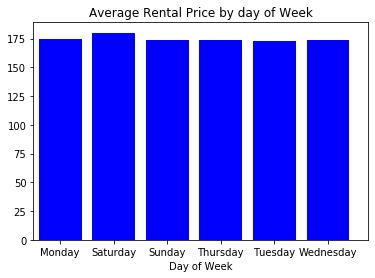

In [5]:
# Data Visualization 2: - Avg Rental Price by Day of Week
#Create Dataframe
listings_by_day = file_two_df.groupby("day_of_week").price.mean().reset_index(0)
listings_by_day.head()
#Need to add sorting by day - -
#Create Bar chart
plt.bar(listings_by_day["day_of_week"], listings_by_day["price"], color="b", align="center")
#Add Chart Titles and any formatting
plt.title("Average Rental Price by day of Week")
plt.xlabel("Day of Week")
plt.xlim(.5, len(listings_by_day)-0.25)
plt.savefig(os.path.join('./avg_rental_price_by_day'))
plt.show()

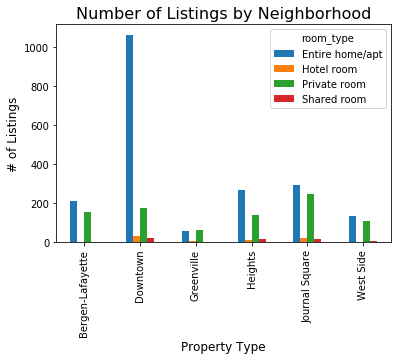

In [6]:
# Data Visualization 3: Neighborhood/Ward Bar Graph
clean_df.groupby(['neighbourhood','room_type']).size().unstack().plot(kind='bar',stacked=False)
plt.title("Number of Listings by Neighborhood", fontsize=16)
plt.ylabel("# of Listings", fontsize=12)
plt.xlabel("Property Type", fontsize=12)
plt.savefig(os.path.join('./number_of_listings_by_neighbourhood'))
plt.show()

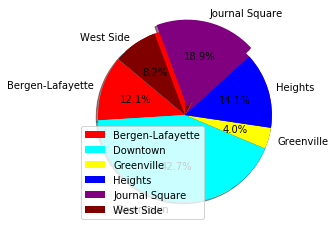

In [7]:
# Data Visualization 4: pie chart

#Get percent of listings by neighbourhood
total_listing_count = clean_df.id.nunique()
ward_df = clean_df.groupby("neighbourhood")
ward_count = clean_df.groupby("neighbourhood").id.nunique()
percentage_by_ward = ward_count/total_listing_count * 100

ward_chart = pd.DataFrame({"Percentage of listings": percentage_by_ward,
                                      "Total number of listings": ward_count})
# Set labels for pie chart
labels = ["Bergen-Lafayette", "Downtown", "Greenville", "Heights", "Journal Square", "West Side"]
sizes = ward_chart.loc[:,"Percentage of listings"]
colors = ["red", "aqua", "yellow", "blue", "purple", "maroon"]
explode = (0, 0, 0, 0, 0.1, 0)
# Plot pie chart
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140)
plt.savefig(os.path.join('./pie_chart_neighbourhoods'))
plt.show()

In [8]:
# Data Visualization 5: Map of Listings
# Store latitude and longitutde in locations
locations = clean_df[["latitude", "longitude"]]

# Create Jersey City Map
jersey_city_coordinates = (40.7178, -74.0431)
jersey_city = gmaps.figure(center = jersey_city_coordinates, zoom_level=12)
# Create Heat Layer
heatmap_layer =  gmaps.heatmap_layer(locations)
jersey_city.add_layer(heatmap_layer)
jersey_city 

Figure(layout=FigureLayout(height='420px'))

In [9]:
# Data Visualization 6: Heatmap of Price of Listings
# Store latitude and longitutde in locations
# Create Jersey City Map
price = clean_df["price"]
jersey_city_coordinates = (40.7178, -74.0431)
jersey_city_price = gmaps.figure(center = jersey_city_coordinates, zoom_level=12)
# Create Heat Layer
heatmap_layer =  gmaps.heatmap_layer(locations, weights=price)
jersey_city_price.add_layer(heatmap_layer)
fig = gmaps.figure()
embed_minimal_html('export.html', views=[fig])
jersey_city_price

Figure(layout=FigureLayout(height='420px'))

In [10]:
#Data Visualization 7: Map of Ward Popularity
ward_a = clean_df.loc[clean_df["neighbourhood"] == "Greenville"]
ward_b = clean_df.loc[clean_df["neighbourhood"] == "West Side"]
ward_c = clean_df.loc[clean_df["neighbourhood"] == "Journal Square"]
ward_d = clean_df.loc[clean_df["neighbourhood"] == "Heights"]
ward_e = clean_df.loc[clean_df["neighbourhood"] == "Downtown"]
ward_f = clean_df.loc[clean_df["neighbourhood"] == "Bergen-Lafayette"]
# Create dataframe for coordinates for all listings by ward
coordinates_a = ward_a[["latitude", "longitude"]]
coordinates_b = ward_b[["latitude", "longitude"]]
coordinates_c = ward_c[["latitude", "longitude"]]
coordinates_d = ward_d[["latitude", "longitude"]]
coordinates_e = ward_e[["latitude", "longitude"]]
coordinates_f = ward_f[["latitude", "longitude"]]
# Set Jersey City coordinates for gmaps
jersey_city_coordinates = (40.7178, -74.0431)
# Set layout for gmaps
figure_layout = {
    'width': '800px',
    'height': '800px',
    'border': '1px solid black'
}
# Plot coordinates by each ward color coded
ward_map = gmaps.figure(center=jersey_city_coordinates, layout=figure_layout, zoom_level=13)
markers_a = gmaps.symbol_layer(coordinates_a, fill_color='red', stroke_color='red', scale=1)
markers_b = gmaps.symbol_layer(coordinates_b, fill_color='aqua', stroke_color='aqua', scale=1)
markers_c = gmaps.symbol_layer(coordinates_c, fill_color='yellow', stroke_color='yellow', scale=1)
markers_d = gmaps.symbol_layer(coordinates_d, fill_color='blue', stroke_color='blue', scale=1)
markers_e = gmaps.symbol_layer(coordinates_e, fill_color='purple', stroke_color='purple', scale=1)
markers_f = gmaps.symbol_layer(coordinates_f, fill_color='maroon', stroke_color='maroon', scale=1)
ward_map.add_layer(markers_a)
ward_map.add_layer(markers_b)
ward_map.add_layer(markers_c)
ward_map.add_layer(markers_d)
ward_map.add_layer(markers_e)
ward_map.add_layer(markers_f)
ward_map


Figure(layout=FigureLayout(border='1px solid black', height='800px', width='800px'))

In [11]:
#Questionable
#Data Visualization 2: Number of Reviews by Type
#number_of_reviews = reviews.plot(kind="bar")
#plt.title("Number of Reviews by Type", fontsize=16)
#plt.ylabel("# of Reviews", fontsize=12)
#plt.xlabel("Room Type", fontsize=12)
#plt.show()

In [12]:
listings = clean_df[['id', 'neighbourhood', 'property_type', 'room_type']]
listings.rename(columns={"id": "listing_id"}, inplace=True)
full_listings = pd.merge(file_two_df, listings, how="left", on=["listing_id"])
avail_listings = full_listings[full_listings.available == 't']
days_grpd = avail_listings.groupby(['neighbourhood', 'room_type'])
nbr_of_listings = days_grpd['listing_id'].nunique()
avg_price = days_grpd['price'].mean()
listing_summary_table = pd.DataFrame({"Number of Listings": nbr_of_listings,
                                     "Avg. Price of Listings": avg_price})
listing_summary_table.style.bar(subset=['Number of Listings', 'Avg. Price of Listings'], color='#5F8BD6').format({"Number of Listings": "{:.0f}", "Avg. Price of Listings": "${:.2f}",
                            "% Passing Math": "{:.1%}", "% Passing Reading": "{:.1%}", "Overall Passing Rate": "{:.1%}"})

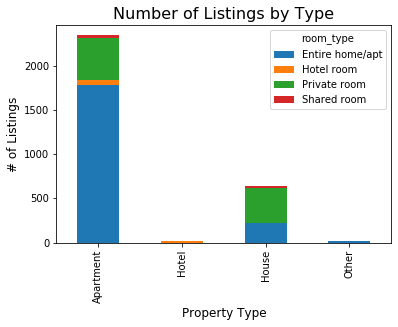

In [13]:
# Data Visualization 1: Number of Listings by Type
clean_df.groupby(['property_type','room_type']).size().unstack().plot(kind='bar',stacked=True)
plt.title("Number of Listings by Type", fontsize=16)
plt.ylabel("# of Listings", fontsize=12)
plt.xlabel("Property Type", fontsize=12)
plt.savefig(os.path.join('./number_of_listings_by_room_type'))
plt.show()

In [14]:
# Left merge file_one_df with file_two_df 
merge_df = file_two_df.merge(file_one_df, left_on="listing_id", right_on="id")

In [15]:
# Create dataframe with only needed columns
clean_merge_df = merge_df[["listing_id", "date", "available", "price_x", "adjusted_price",
                         "minimum_nights_x", "maximum_nights_x", "day_of_week", "property_type", 
                          "accommodates", "bathrooms", "bedrooms", "price_y", "guests_included", "neighbourhood_cleansed"]]

# Rename columns
clean_merge_df = clean_merge_df.rename(columns={"price_x": "price_by_date",
                              "minimum_nights_x": "minimum_nights",
                              "maximum_nights_x": "maximum_nights",
                              "price_y":"price"})

In [16]:
# Create bin to re-categorize date by months
bins = [datetime.datetime(2019, 9, 30), 
        datetime.datetime(2019, 10, 31), 
        datetime.datetime(2019, 11, 30), 
        datetime.datetime(2019, 12, 31), 
        datetime.datetime(2020, 1, 31), 
        datetime.datetime(2020, 2, 29), 
        datetime.datetime(2020, 3, 31), 
        datetime.datetime(2020, 4, 30), 
        datetime.datetime(2020, 5, 31), 
        datetime.datetime(2020, 6, 30), 
        datetime.datetime(2020, 7, 31), 
        datetime.datetime(2020, 8, 31), 
        datetime.datetime(2020, 9, 30)]

# Create group names for new Month field
group_names = ["Oct 2019", "Nov 2019", "Dec 2019", "Jan 2020", "Feb 2020", "Mar 2020", "Apr 2020", "May 2020", "Jun 2020",
            "July 2020", "Aug 2020", "Sept 2020"]

# Create new column "month" 
clean_merge_df["month"] = pd.cut(clean_merge_df["date"], bins, labels=group_names)

In [17]:
# Create dataframes by neightborhood type
ward_a_price_df = clean_merge_df.loc[clean_merge_df["neighbourhood_cleansed"] == "Ward A (councilmember Denise Ridley)"]
ward_b_price_df = clean_merge_df.loc[clean_merge_df["neighbourhood_cleansed"] == "Ward B (councilmember Mira Prinz-Arey)"]
ward_c_price_df = clean_merge_df.loc[clean_merge_df["neighbourhood_cleansed"] == "Ward C (councilmember Richard Boggiano)"]
ward_d_price_df = clean_merge_df.loc[clean_merge_df["neighbourhood_cleansed"] == "Ward D (councilmember Michael Yun)"]
ward_e_price_df = clean_merge_df.loc[clean_merge_df["neighbourhood_cleansed"] == "Ward E (councilmember James Solomon)"]
ward_f_price_df = clean_merge_df.loc[clean_merge_df["neighbourhood_cleansed"] == "Ward F (councilmember Jermaine D. Robinson)"]

In [18]:
# Calculate average price per listing by month for Ward A
ward_a_oct_2019 = ward_a_price_df.loc[ward_a_price_df["month"] == "Oct 2019"].price_by_date.mean()
ward_a_nov_2019 = ward_a_price_df.loc[ward_a_price_df["month"] == "Nov 2019"].price_by_date.mean()
ward_a_dec_2019 = ward_a_price_df.loc[ward_a_price_df["month"] == "Dec 2019"].price_by_date.mean()
ward_a_jan_2020 = ward_a_price_df.loc[ward_a_price_df["month"] == "Jan 2020"].price_by_date.mean()
ward_a_feb_2020 = ward_a_price_df.loc[ward_a_price_df["month"] == "Feb 2020"].price_by_date.mean()
ward_a_mar_2020 = ward_a_price_df.loc[ward_a_price_df["month"] == "Mar 2020"].price_by_date.mean()
ward_a_apr_2020 = ward_a_price_df.loc[ward_a_price_df["month"] == "Apr 2020"].price_by_date.mean()
ward_a_may_2020 = ward_a_price_df.loc[ward_a_price_df["month"] == "May 2020"].price_by_date.mean()
ward_a_jun_2020 = ward_a_price_df.loc[ward_a_price_df["month"] == "Jun 2020"].price_by_date.mean()
ward_a_july_2020 = ward_a_price_df.loc[ward_a_price_df["month"] == "July 2020"].price_by_date.mean()
ward_a_aug_2020 = ward_a_price_df.loc[ward_a_price_df["month"] == "Aug 2020"].price_by_date.mean()
ward_a_sept_2020 = ward_a_price_df.loc[ward_a_price_df["month"] == "Sept 2020"].price_by_date.mean()

In [19]:
# Calculate average price per listing by month for Ward B
ward_b_oct_2019 = ward_b_price_df.loc[ward_b_price_df["month"] == "Oct 2019"].price_by_date.mean()
ward_b_nov_2019 = ward_b_price_df.loc[ward_b_price_df["month"] == "Nov 2019"].price_by_date.mean()
ward_b_dec_2019 = ward_b_price_df.loc[ward_b_price_df["month"] == "Dec 2019"].price_by_date.mean()
ward_b_jan_2020 = ward_b_price_df.loc[ward_b_price_df["month"] == "Jan 2020"].price_by_date.mean()
ward_b_feb_2020 = ward_b_price_df.loc[ward_b_price_df["month"] == "Feb 2020"].price_by_date.mean()
ward_b_mar_2020 = ward_b_price_df.loc[ward_b_price_df["month"] == "Mar 2020"].price_by_date.mean()
ward_b_apr_2020 = ward_b_price_df.loc[ward_b_price_df["month"] == "Apr 2020"].price_by_date.mean()
ward_b_may_2020 = ward_b_price_df.loc[ward_b_price_df["month"] == "May 2020"].price_by_date.mean()
ward_b_jun_2020 = ward_b_price_df.loc[ward_b_price_df["month"] == "Jun 2020"].price_by_date.mean()
ward_b_july_2020 = ward_b_price_df.loc[ward_b_price_df["month"] == "July 2020"].price_by_date.mean()
ward_b_aug_2020 = ward_b_price_df.loc[ward_b_price_df["month"] == "Aug 2020"].price_by_date.mean()
ward_b_sept_2020 = ward_b_price_df.loc[ward_b_price_df["month"] == "Sept 2020"].price_by_date.mean()

In [20]:
# Calculate average price per listing by month for Ward C
ward_c_oct_2019 = ward_c_price_df.loc[ward_c_price_df["month"] == "Oct 2019"].price_by_date.mean()
ward_c_nov_2019 = ward_c_price_df.loc[ward_c_price_df["month"] == "Nov 2019"].price_by_date.mean()
ward_c_dec_2019 = ward_c_price_df.loc[ward_c_price_df["month"] == "Dec 2019"].price_by_date.mean()
ward_c_jan_2020 = ward_c_price_df.loc[ward_c_price_df["month"] == "Jan 2020"].price_by_date.mean()
ward_c_feb_2020 = ward_c_price_df.loc[ward_c_price_df["month"] == "Feb 2020"].price_by_date.mean()
ward_c_mar_2020 = ward_c_price_df.loc[ward_c_price_df["month"] == "Mar 2020"].price_by_date.mean()
ward_c_apr_2020 = ward_c_price_df.loc[ward_c_price_df["month"] == "Apr 2020"].price_by_date.mean()
ward_c_may_2020 = ward_c_price_df.loc[ward_c_price_df["month"] == "May 2020"].price_by_date.mean()
ward_c_jun_2020 = ward_c_price_df.loc[ward_c_price_df["month"] == "Jun 2020"].price_by_date.mean()
ward_c_july_2020 = ward_c_price_df.loc[ward_c_price_df["month"] == "July 2020"].price_by_date.mean()
ward_c_aug_2020 = ward_c_price_df.loc[ward_c_price_df["month"] == "Aug 2020"].price_by_date.mean()
ward_c_sept_2020 = ward_c_price_df.loc[ward_c_price_df["month"] == "Sept 2020"].price_by_date.mean()

In [21]:
# Calculate average price per listing by month for Ward D
ward_d_oct_2019 = ward_d_price_df.loc[ward_d_price_df["month"] == "Oct 2019"].price_by_date.mean()
ward_d_nov_2019 = ward_d_price_df.loc[ward_d_price_df["month"] == "Nov 2019"].price_by_date.mean()
ward_d_dec_2019 = ward_d_price_df.loc[ward_d_price_df["month"] == "Dec 2019"].price_by_date.mean()
ward_d_jan_2020 = ward_d_price_df.loc[ward_d_price_df["month"] == "Jan 2020"].price_by_date.mean()
ward_d_feb_2020 = ward_d_price_df.loc[ward_d_price_df["month"] == "Feb 2020"].price_by_date.mean()
ward_d_mar_2020 = ward_d_price_df.loc[ward_d_price_df["month"] == "Mar 2020"].price_by_date.mean()
ward_d_apr_2020 = ward_d_price_df.loc[ward_d_price_df["month"] == "Apr 2020"].price_by_date.mean()
ward_d_may_2020 = ward_d_price_df.loc[ward_d_price_df["month"] == "May 2020"].price_by_date.mean()
ward_d_jun_2020 = ward_d_price_df.loc[ward_d_price_df["month"] == "Jun 2020"].price_by_date.mean()
ward_d_july_2020 = ward_d_price_df.loc[ward_d_price_df["month"] == "July 2020"].price_by_date.mean()
ward_d_aug_2020 = ward_d_price_df.loc[ward_d_price_df["month"] == "Aug 2020"].price_by_date.mean()
ward_d_sept_2020 = ward_d_price_df.loc[ward_d_price_df["month"] == "Sept 2020"].price_by_date.mean()

In [22]:
# Calculate average price per listing by month for Ward E
ward_e_oct_2019 = ward_e_price_df.loc[ward_e_price_df["month"] == "Oct 2019"].price_by_date.mean()
ward_e_nov_2019 = ward_e_price_df.loc[ward_e_price_df["month"] == "Nov 2019"].price_by_date.mean()
ward_e_dec_2019 = ward_e_price_df.loc[ward_e_price_df["month"] == "Dec 2019"].price_by_date.mean()
ward_e_jan_2020 = ward_e_price_df.loc[ward_e_price_df["month"] == "Jan 2020"].price_by_date.mean()
ward_e_feb_2020 = ward_e_price_df.loc[ward_e_price_df["month"] == "Feb 2020"].price_by_date.mean()
ward_e_mar_2020 = ward_e_price_df.loc[ward_e_price_df["month"] == "Mar 2020"].price_by_date.mean()
ward_e_apr_2020 = ward_e_price_df.loc[ward_e_price_df["month"] == "Apr 2020"].price_by_date.mean()
ward_e_may_2020 = ward_e_price_df.loc[ward_e_price_df["month"] == "May 2020"].price_by_date.mean()
ward_e_jun_2020 = ward_e_price_df.loc[ward_e_price_df["month"] == "Jun 2020"].price_by_date.mean()
ward_e_july_2020 = ward_e_price_df.loc[ward_e_price_df["month"] == "July 2020"].price_by_date.mean()
ward_e_aug_2020 = ward_e_price_df.loc[ward_e_price_df["month"] == "Aug 2020"].price_by_date.mean()
ward_e_sept_2020 = ward_e_price_df.loc[ward_e_price_df["month"] == "Sept 2020"].price_by_date.mean()

In [23]:
# Calculate average price per listing by month for Ward F
ward_f_oct_2019 = ward_f_price_df.loc[ward_f_price_df["month"] == "Oct 2019"].price_by_date.mean()
ward_f_nov_2019 = ward_f_price_df.loc[ward_f_price_df["month"] == "Nov 2019"].price_by_date.mean()
ward_f_dec_2019 = ward_f_price_df.loc[ward_f_price_df["month"] == "Dec 2019"].price_by_date.mean()
ward_f_jan_2020 = ward_f_price_df.loc[ward_f_price_df["month"] == "Jan 2020"].price_by_date.mean()
ward_f_feb_2020 = ward_f_price_df.loc[ward_f_price_df["month"] == "Feb 2020"].price_by_date.mean()
ward_f_mar_2020 = ward_f_price_df.loc[ward_f_price_df["month"] == "Mar 2020"].price_by_date.mean()
ward_f_apr_2020 = ward_f_price_df.loc[ward_f_price_df["month"] == "Apr 2020"].price_by_date.mean()
ward_f_may_2020 = ward_f_price_df.loc[ward_f_price_df["month"] == "May 2020"].price_by_date.mean()
ward_f_jun_2020 = ward_f_price_df.loc[ward_f_price_df["month"] == "Jun 2020"].price_by_date.mean()
ward_f_july_2020 = ward_f_price_df.loc[ward_f_price_df["month"] == "July 2020"].price_by_date.mean()
ward_f_aug_2020 = ward_f_price_df.loc[ward_f_price_df["month"] == "Aug 2020"].price_by_date.mean()
ward_f_sept_2020 = ward_f_price_df.loc[ward_f_price_df["month"] == "Sept 2020"].price_by_date.mean()

In [24]:
# Create lists of average price by month to plot on line graph
ward_a_ave_price = [ward_a_oct_2019, ward_a_nov_2019, ward_a_dec_2019, ward_a_jan_2020, ward_a_feb_2020, 
                    ward_a_mar_2020, ward_a_apr_2020, ward_a_may_2020, ward_a_jun_2020, ward_a_july_2020,
                   ward_a_aug_2020, ward_a_sept_2020]
ward_b_ave_price = [ward_b_oct_2019, ward_b_nov_2019, ward_b_dec_2019, ward_b_jan_2020, ward_b_feb_2020, 
                    ward_b_mar_2020, ward_b_apr_2020, ward_b_may_2020, ward_b_jun_2020, ward_b_july_2020,
                   ward_b_aug_2020, ward_b_sept_2020]
ward_c_ave_price = [ward_c_oct_2019, ward_c_nov_2019, ward_c_dec_2019, ward_c_jan_2020, ward_c_feb_2020, 
                    ward_c_mar_2020, ward_c_apr_2020, ward_c_may_2020, ward_c_jun_2020, ward_c_july_2020,
                   ward_c_aug_2020, ward_c_sept_2020]
ward_d_ave_price = [ward_d_oct_2019, ward_d_nov_2019, ward_d_dec_2019, ward_d_jan_2020, ward_d_feb_2020, 
                    ward_d_mar_2020, ward_d_apr_2020, ward_d_may_2020, ward_d_jun_2020, ward_d_july_2020,
                   ward_d_aug_2020, ward_d_sept_2020]
ward_e_ave_price = [ward_e_oct_2019, ward_e_nov_2019, ward_e_dec_2019, ward_e_jan_2020, ward_e_feb_2020, 
                    ward_e_mar_2020, ward_e_apr_2020, ward_e_may_2020, ward_e_jun_2020, ward_e_july_2020,
                   ward_e_aug_2020, ward_e_sept_2020]
ward_f_ave_price = [ward_f_oct_2019, ward_f_nov_2019, ward_f_dec_2019, ward_f_jan_2020, ward_f_feb_2020, 
                    ward_f_mar_2020, ward_f_apr_2020, ward_f_may_2020, ward_f_jun_2020, ward_f_july_2020,
                   ward_f_aug_2020, ward_f_sept_2020]

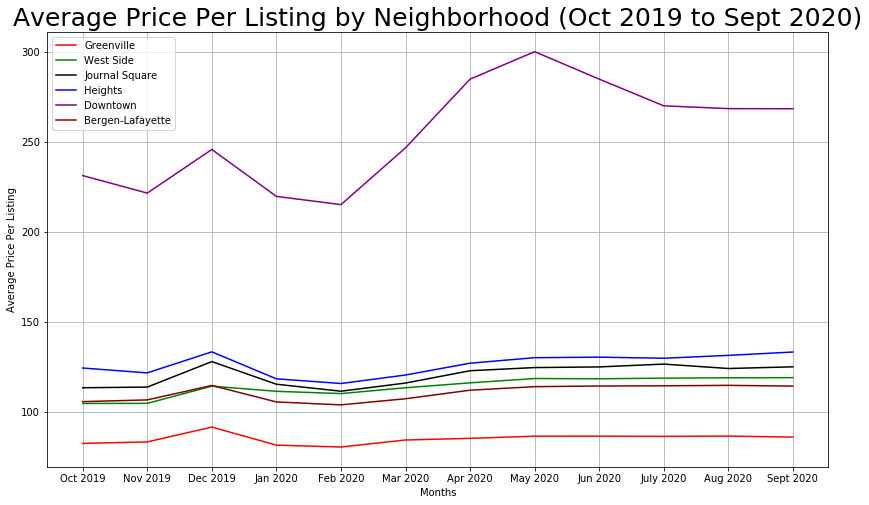

In [25]:
# Rearrange size of graph
fig = plt.figure(figsize = (14,8))

# Plot average price over months for each neighborhood and color code accordingly
plt.plot(group_names, ward_a_ave_price, color="red", label="Greenville")
plt.plot(group_names, ward_b_ave_price, color="green", label="West Side")
plt.plot(group_names, ward_c_ave_price, color="black", label="Journal Square")
plt.plot(group_names, ward_d_ave_price, color="blue", label="Heights")
plt.plot(group_names, ward_e_ave_price, color="purple", label="Downtown")
plt.plot(group_names, ward_f_ave_price, color="maroon", label="Bergen-Lafayette")

# Create title of graph and labels for x and y axis
plt.title('Average Price Per Listing by Neighborhood (Oct 2019 to Sept 2020)', fontdict = {'fontsize' : 25})
plt.xlabel("Months")
plt.ylabel("Average Price Per Listing")

# Create gridlines and add legend
plt.grid()
plt.legend()
plt.savefig(os.path.join('./average_price_per_listing_by_neighbourhood'))
plt.show()